# Pink Floyd Lyrics

##### The goal of the project is to analyse all Pink Floyd lyrics, and then build a model that can return a new song based on user input of 2 key words.

#### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
import sys

from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
import re

In [2]:
!pip install openpyxl

In [3]:
file = "../raw_data/pink_floyd_lyrics.csv"
df = pd.read_csv(file, decimal=",")


### Formatting the DataFrame

In [4]:
df.sample(5)

,album,song_title,year,lyrics
30,More (Original Film Soundtrack),Ibiza Bar,1969-06-13,I’m so afraid\nOf all the mistakes that I’ve m...
22,More (Original Film Soundtrack),Quicksilver,1969-06-13,NaN
136,The Division Bell,Wearing the Inside Out,1994-03-28,From morning to night I stayed out of sight\nD...
147,The Endless River,Unsung,2014-11-07,NaN
50,Meddle,Seamus,1971-10-31,"I was in the kitchen\nSeamus, that’s the dog, ..."


In [11]:

df['year'] = df['year'].apply(lambda x: (x.split('-')[0]))
df.head()

,album,song_title,year,lyrics
0,The Piper at the Gates of Dawn,Astronomy Domine,1967,"""Moon in both [houses]...""...Scorpio, [Arabian..."
1,The Piper at the Gates of Dawn,Lucifer Sam,1967,"Lucifer Sam, siam cat\nAlways sitting by your ..."
2,The Piper at the Gates of Dawn,Matilda Mother,1967,There was a king who ruled the land\nHis Majes...
3,The Piper at the Gates of Dawn,Flaming,1967,Alone in the clouds all blue\nLying on an eide...
4,The Piper at the Gates of Dawn,Pow R. Toc H.,1967,TCH TCH\nAHH (AHH)\nTCH TCH\nAHH AHH\nDoi doi\...


### Explore The Data

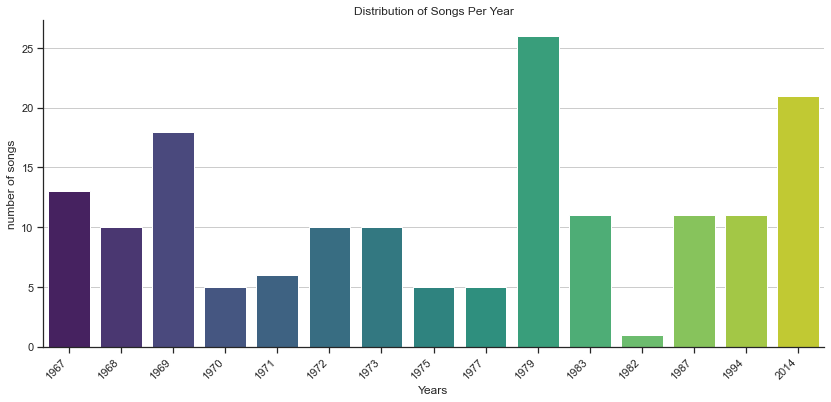

In [36]:
plt.figure(figsize=(14,6),edgecolor='blue')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    )
plt.grid()



    
sns.set_theme(style="darkgrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

f = sns.countplot(x="year", 
                  data=df, 
                  palette="viridis", 
                  saturation=0.75, 
                  dodge=True).set(ylabel='number of songs',xlabel='Years', 
                                  title='Distribution of Songs Per Year'
                                                    )
                  
                  


In [37]:
def count_lines(text):
    count,k,p=0,0,0
    for i in text.split('\n'):
        res = re.findall("[a-zA-Z’]+", i)
        if res:
            p+=1
        if len(res)>2:
            k+=1
            count+=len(res)
    if k!=0:
        mean = count/k
    else:
        mean = 2
    total = p
    big_lines = k
    small_lines = (p-k)
  
    return mean,total,big_lines,small_lines

cl = []
for j in range(0,len(df)):
    if type(df.lyrics.iloc[j])==str :
        m,t,bl,sl = count_lines(df.lyrics.iloc[j])
        year = int(df.year.iloc[j])
        if sl!=0:
            l = [m,t,bl,sl,bl/sl,year]
        else:
            l = [m,t,bl,sl,0,year]
        cl.append(l)

df_countlines = pd.DataFrame(cl,columns=['mean_lines','total_lines','big_lines','small_lines','ratio_of_bl_&_sl','year'])
df_countlines.sample(30)

,mean_lines,total_lines,big_lines,small_lines,ratio_of_bl_&_sl,year
121,6.588235,35,34,1,34.000000,1994
5,4.692308,20,13,7,1.857143,1967
65,9.166667,6,6,0,0.000000,1977
93,8.750000,25,24,1,24.000000,1983
101,7.696970,34,33,1,33.000000,1983
108,5.966667,30,30,0,0.000000,1987
49,15.500000,3,2,1,2.000000,1973
91,6.400000,10,10,0,0.000000,1979
106,6.444444,36,36,0,0.000000,1987
69,7.428571,9,7,2,3.500000,1979


/Users/kelvinpurdom/.pyenv/versions/lewagon/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


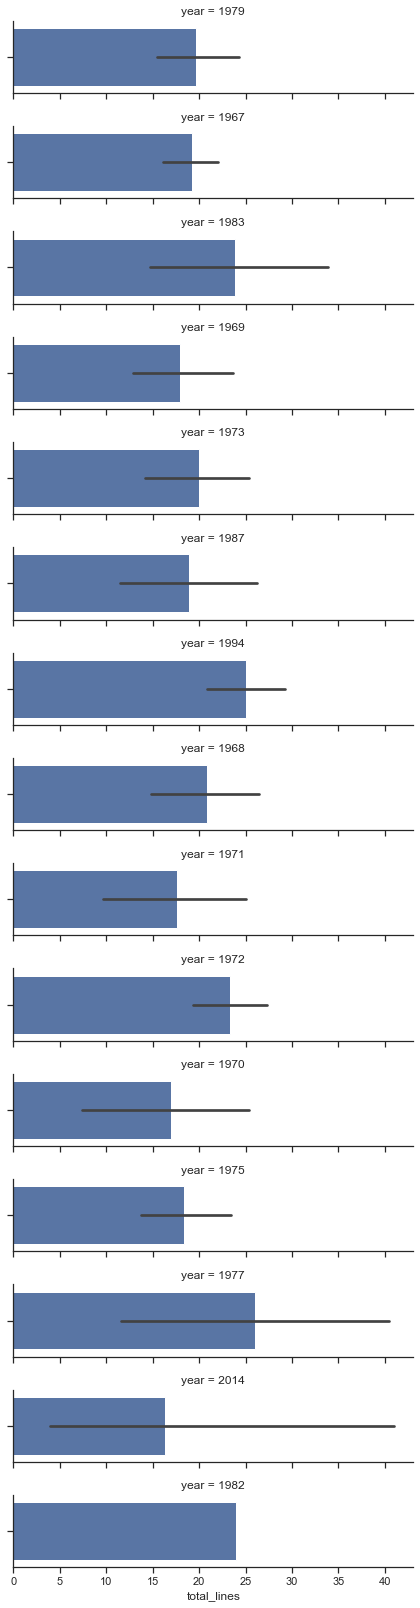

In [38]:
ordered_days = df_countlines.year.value_counts().index
g = sns.FacetGrid(df_countlines, row="year", row_order=ordered_days,
                  height=1.5, aspect=4,)
g.map(sns.barplot, "total_lines");


### Start Tokenizing

In [39]:
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts([df.lyrics.iloc[1].replace('\n',' \n ')])
tokenizer.word_index

{'side': 1,
 'that': 2,
 'cat’s': 3,
 'something': 4,
 'i': 5,
 'can’t': 6,
 'explain': 7,
 'cat': 8,
 'you’re': 9,
 'a': 10,
 'the': 11,
 'be': 12,
 'lucifer': 13,
 'always': 14,
 'by': 15,
 'your': 16,
 'around': 17,
 'sam': 18,
 'siam': 19,
 'sitting': 20,
 'jennifer': 21,
 'gentle': 22,
 'witch': 23,
 'left': 24,
 'he’s': 25,
 'right': 26,
 'oh': 27,
 'no': 28,
 'go': 29,
 'to': 30,
 'sea': 31,
 'hip': 32,
 'ship’s': 33,
 'somewhere': 34,
 'anywhere': 35,
 'at': 36,
 'night': 37,
 'prowling': 38,
 'sifting': 39,
 'sand': 40,
 'hiding': 41,
 'on': 42,
 'ground': 43,
 'he’ll': 44,
 'found': 45,
 'when': 46}

In [40]:
text = df.lyrics.iloc[1].split('\n')
text = [re.sub(r'\d+', '', i) for i in text]
corpus = list(set(text))


In [41]:
corpus


['',
 'Lucifer, go to sea',
 'Be a hip cat, be a ship’s cat',
 'He’ll be found when you’re around',
 'At night prowling, sifting sand',
 'Always sitting by your side',
 'Somewhere, anywhere',
 'Hiding around on the ground',
 'Oh, no!',
 'Lucifer Sam, siam cat',
 'Always by your side',
 'You’re the left side, he’s the right side',
 'That cat’s something I can’t explain',
 'Jennifer Gentle, you’re a witch']

In [42]:
lines=[]

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    print('--'*25)
    print(token_list)
    print('-'*25)
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        print(n_gram_sequence)
        
lines

--------------------------------------------------
[]
-------------------------
--------------------------------------------------
[13, 29, 30, 31]
-------------------------
[13, 29]
[13, 29, 30]
[13, 29, 30, 31]
--------------------------------------------------
[12, 10, 32, 8, 12, 10, 33, 8]
-------------------------
[12, 10]
[12, 10, 32]
[12, 10, 32, 8]
[12, 10, 32, 8, 12]
[12, 10, 32, 8, 12, 10]
[12, 10, 32, 8, 12, 10, 33]
[12, 10, 32, 8, 12, 10, 33, 8]
--------------------------------------------------
[44, 12, 45, 46, 9, 17]
-------------------------
[44, 12]
[44, 12, 45]
[44, 12, 45, 46]
[44, 12, 45, 46, 9]
[44, 12, 45, 46, 9, 17]
--------------------------------------------------
[36, 37, 38, 39, 40]
-------------------------
[36, 37]
[36, 37, 38]
[36, 37, 38, 39]
[36, 37, 38, 39, 40]
--------------------------------------------------
[14, 20, 15, 16, 1]
-------------------------
[14, 20]
[14, 20, 15]
[14, 20, 15, 16]
[14, 20, 15, 16, 1]
----------------------------------------

[]

In [43]:
def ngram(token_list):
    ng = []
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        ng.append(n_gram_sequence)
    return ng


In [44]:
df.iloc[[0]].lyrics.iloc[0]

'"Moon in both [houses]..."...Scorpio, [Arabian Skies], Libra..."...Pluto was not discovered until 1930..."\nLime and limpid green, a second scene\nA fight between the blue you once knew\nFloating down, the sound resounds\nAround the icy waters underground\nJupiter and Saturn, Oberon, Miranda and Titania\nNeptune, Titan, stars can frighten\n\nBlinding signs flap\nFlicker, flicker, flicker, blam\nPow, pow\nStairway scare Dan Dare who’s there?\n\nLime and limpid green, the sound surrounds\nThe icy waters under\nLime and limpid green, the sound surrounds\nThe icy waters underground'

In [45]:
len(df)

163

In [46]:
def seqform(data):
  
    tokenise = Tokenizer()
    input_sequences = []
    corpus = []
    k=0

    for i in range(0,len(df)):
    
        text = df.iloc[[i]].lyrics.iloc[0]
        if type(text)==float:
            pass
        else:
            text = text.lower().split("\n")
            text = [re.sub(r'\d+', '', i) for i in text]
            text = list(set(text))
            if text==' ':
                pass
            else:
                corpus.extend(text)
            k+=1
            
    tokenise.fit_on_texts(corpus)
    for line in corpus:
        token_list = tokenise.texts_to_sequences([line])[0]
        input_sequences.extend(ngram(token_list))
 
  
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,
                       maxlen = max_sequence_len, padding='pre'))
        
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    fin_data = pd.DataFrame(np.hstack((predictors, label.reshape(-1,1))),columns=np.hstack((np.arange(1,predictors.shape[1]+1),np.array(['label']))))
    total_words = len(tokenise.word_index) + 1
    print('{} number of lyrics inputted'.format(k))
        
    return fin_data,tokenise,max_sequence_len,total_words,predictors,label

In [47]:
fdf,tokenise,max_sequence_len,total_words,predictors,label = seqform(df)
print(fdf.shape,max_sequence_len,total_words)

125 number of lyrics inputted
(13839, 88) 88 2983


In [48]:
fdf.sample(10)

,1,2,3,4,5,6,7,8,9,10,...,79,80,81,82,83,84,85,86,87,label
12792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,39,15,1302
4100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,962,15,432,4,176,4
3289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,7,214,3,2,31
2691,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,575,864,286,1631,528,1632
8069,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,60,5
4169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,121,1805,121
4077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,205,2
448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,40,1,207,11,882,4
910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,102,17
9305,0,0,0,0,0,0,0,0,0,0,...,544,253,6,1,2330,2331,76,21,2332,6


In [49]:
fdf.to_csv('fin_df.csv',index=False)

### Find Params for the model

In [50]:
print(fdf.shape)
print(fdf.values.max())

(13839, 88)
2982


In [51]:
dataX = [fdf.iloc[i,0:87].tolist() for i in range(0,fdf.shape[0])]
dataY = [fdf.iloc[i,87] for i in range(0,fdf.shape[0])]
print(len(dataX))
print(len(dataY))

13839
13839


In [52]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (13839, 87, 1))

# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [53]:
len(y[0])
print(predictors.shape)
print(label.shape)
print(X.shape,y.shape)
print(total_words,max_sequence_len)

(13839, 87)
(13839,)
(13839, 87, 1) (13839, 2983)
2983 88


### Designing the LSTM Model

In [54]:
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
# Add an LSTM Layer
model.add(Bidirectional(LSTM(150, return_sequences=True)))  
# A dropout layer for regularisation
model.add(Dropout(0.2))
# Add another LSTM Layer
model.add(LSTM(100)) 
model.add(Dense(total_words/2, activation='relu'))  
# In the last layer, the shape should be equal to the total number of words present in our corpus
model.add(Dense(y.shape[1], activation='softmax'))
#model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

2022-08-08 15:58:34.904154: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 87, 150)           447450    
                                                                 
 bidirectional (Bidirectiona  (None, 87, 300)          361200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 87, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1491)              150591    
                                                                 
 dense_1 (Dense)             (None, 2983)              4450636   
                                                        

In [55]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [33]:
model.fit(X,y, epochs= 10,callbacks=callbacks_list)

Epoch 1/10
  9/433 [..............................] - ETA: 2:21 - loss: 7.9010 - accuracy: 0.0243

KeyboardInterrupt: 

### Training the Model on improved weights

In [56]:
filename = "weights-improvement-10-4.5234.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')
model.fit(X, y, epochs=20, callbacks=callbacks_list)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'weights-improvement-10-4.5234.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [35]:
model.save_weights('my_model_weights.h5')
model.save('my_model.h5')


In [36]:
model.save('saved_model/my_model')

2022-07-28 14:50:34.236334: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


### Func to making lyrics

In [57]:
def make_lyrics(seed_text, next_words):
    pred_index=[]
    for i in range(next_words):
        token_list = tokenise.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        #print(token_list.shape)
        token_list = np.reshape(token_list, (1, max_sequence_len-1, 1))
        predicted = model.predict(token_list, verbose=0)
        predicted_index =  np.argmax(predicted)
        pred_index.append(predicted_index)
        
        output_word = ""
        for word, index in tokenise.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)
    return seed_text


In [58]:
reverse_word_map = dict(map(reversed, tokenise.word_index.items()))
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
pattern_val = [i for i in pattern if i > 0]
print("Seed:")
print(' '.join([reverse_word_map.get(value) for value in pattern_val]))
seed_text = [reverse_word_map.get(value)+' ' for value in pattern_val]

Seed:
will


### Playing with the model

In [62]:
line1 = make_lyrics(('love'), 20)

love ’round ’round ’round fitted star ’round star ’round ’round star ’round star ’round ’round star ’round star ’round star ’round
